In [1]:
# pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as smf
import statsmodels.formula.api as smf
from scipy.stats import gamma, poisson
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Úloha 1

## Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

Načtení dat

In [3]:
# Load data from Excel file
data = pd.read_excel('C:\\Users\\M\\OneDrive\\FIT\\NSPE\\MSP\\Projekt-2\\Projekt-2_Data.xlsx')

# Display the loaded data
print(data)


       uloha_1 a)  uloha_1 b)_prior  skupina  uloha_1 b)_pozorování
0             2.0          3.634785        0               3.626656
1             2.0          2.868113        0               3.008269
2             1.0          2.149160        0               2.989829
3             3.0          4.263065        0               2.371630
4             0.0          2.594745        0               4.009366
...           ...               ...      ...                    ...
99995         NaN          1.725637     9999                    NaN
99996         NaN          4.048414     9999                    NaN
99997         NaN          3.000662     9999                    NaN
99998         NaN          3.058451     9999                    NaN
99999         NaN          4.487418     9999                    NaN

[100000 rows x 4 columns]


Z expertního odhadu víme, že každou 1 ms dojde k 2 připojením. Expertní odhad parametru lambda je tedy roven 2.

Z tabulek (https://en.wikipedia.org/wiki/Conjugate_prior) vidíme, že konjugované apriorní rozdělení je Gamma rozdělení s parametry 'k' a 'lambda'. Víme, že máme 2 připojení za 1 ms, tj. E(X) = k/lambda = 2/1 = 2.



In [4]:
# Expert information
lambda_expert = 2

# Generate x values for the Poisson distribution
x_values = np.arange(0, 15)

# Calculate PMF values for the apriori distribution
pmf_apriori = poisson.pmf(x_values, mu=lambda_expert)
pmf_aposteriori = poisson.pmf(x_values, mu=2*lambda_expert)


# Calculate PDF values for a smoother representation
pdf_apriori = gamma.pdf(x_values, a=lambda_expert**2, scale=1/lambda_expert)

# Plot the apriori distribution
plt.figure(figsize=(10, 6))
plt.bar(x_values, pmf_apriori, label='Apriorní (Poisson)', alpha=0.7)
# plt.bar(x_values, pmf_aposteriori, label='Aposteriorni (Poisson)', alpha=0.7)

plt.plot(x_values, pdf_apriori, color='red', label='PDF Estimate', linewidth=2)
plt.title('Apriorní Hustota Parametru Poissonova Rozdělení 𝜆')
plt.xlabel('𝜆')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 120582 (\N{MATHEMATICAL ITALIC SMALL LAMDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


## Aproximace diskrétním rozdělením

# Úloha 2

### Čištění dat

In [5]:
# read data from the second sheet
data = pd.read_excel('C:\\Users\\M\\OneDrive\\FIT\\NSPE\\MSP\\Projekt-2\\Projekt-2_Data.xlsx', sheet_name=1)
# Display the loaded data
print(data)


      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717         47
1        iOS         7549          0.3461        0.6539         46
2    Windows         8855          0.2178        0.7822         55
3    Android         8870          0.0794        0.9206         56
4      MacOS         9559          0.7282        0.2718         76
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026         28
498    MacOS         1392          0.2373        0.7627         24
499      iOS         6014          0.8112        0.1888         54
500  Android         5118          0.2345        0.7655         39
501    MacOS         2660          0.9390        0.0610         55

[502 rows x 5 columns]


Vidíme, že atributy InteractingPct a ScrollingPct jsou na sobě zřejmě závislé, neboť lze spočítat jeden z druhého a naopak (např. 1-InteractingPct=ScrollingPct). Můžeme si tedy bez újmy na kvalitě dovolit vyřadit 1 z těchto parametrů.

In [6]:
# drop ScrollingPct column
data = data.drop('ScrollingPct', axis=1)
data = data.rename(columns={'Ping [ms]': 'Ping'})
print(data)

      OSType  ActiveUsers  InteractingPct  Ping
0        iOS         4113          0.8283    47
1        iOS         7549          0.3461    46
2    Windows         8855          0.2178    55
3    Android         8870          0.0794    56
4      MacOS         9559          0.7282    76
..       ...          ...             ...   ...
497      iOS         5315          0.1974    28
498    MacOS         1392          0.2373    24
499      iOS         6014          0.8112    54
500  Android         5118          0.2345    39
501    MacOS         2660          0.9390    55

[502 rows x 4 columns]


### Splnění předpokladů lineární regrese a základní regresní diagnostiky

### Analýza odlehlých hodnot

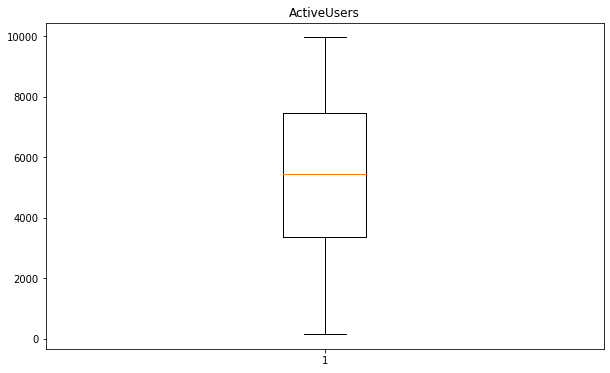

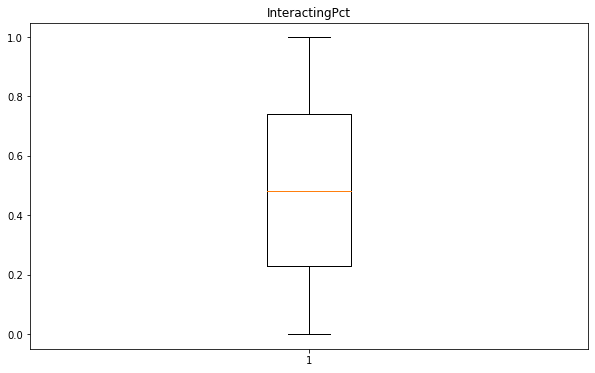

       ActiveUsers  InteractingPct        Ping
count   502.000000      502.000000  502.000000
mean   5485.830677        0.488613   50.545817
std    2548.935679        0.296000   14.797937
min     153.000000        0.000500   11.000000
25%    3357.500000        0.229300   40.000000
50%    5456.000000        0.482950   52.000000
75%    7461.500000        0.742475   60.000000
max    9953.000000        0.998600   90.000000


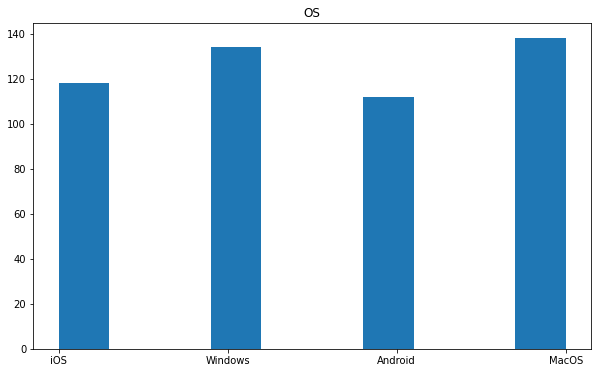

In [7]:
# using visualizations to explore the data (outliers), for each column extra boxplot with appropriate range of values
# for each column extra boxplot with appropriate range of values in one figure
plt.figure(figsize=(10, 6))
plt.boxplot(data['ActiveUsers'])
plt.title('ActiveUsers')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(data['InteractingPct'])
plt.title('InteractingPct')
plt.show()

# analyze the data using the describe() method
print(data.describe())

# histogram for OS column
plt.figure(figsize=(10, 6))
plt.hist(data['OSType'])
plt.title('OS')
plt.show()

### Others

In [9]:
# 1. option
mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType) + ActiveUsers*InteractingPct', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        11:41:26   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [18]:
# 2. option with dummy variables
# create dummy variables for OS column (one-hot encoding) and use it in the model instead of the original column OS column 
data1 = pd.get_dummies(data, columns=['OSType']).astype(float)

mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType_Android) + C(OSType_iOS) + C(OSType_Windows) + C(OSType_MacOS) + ActiveUsers*InteractingPct', data=data1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        11:58:09   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Je logické, že pro 4 kategorie nám stačí mít v modelu pouze 3, jelikož 4. kategorii jsme schopni dopočítat.

### Předpoklady lineární regrese a základní regresní diagnostiky

Diagnostika
- ověření základních předpokladů MNČ (kritika metody):
ověření stejného rozptylu, ověření autokorelace (Durbin-Watson), ověření normality (Omnibus; Prob(Omnibus); Jarque-Bera (JB); Prob(JB))
- ověření vhodnosti modelu pro daná data (kritika modelu):
ověření, zda v datech je nějaká závislost, ověření kvality modelu
- vhodnosti dat pro navržený regresní model (kritika dat):
zjištění vlivných bodů, vlivné body v nezávisle proměnných, vlivné body v závisle proměnných 